## Crypto Forecasting
Personal project to forecast BTC & Ethereum

### Binance Library

In [323]:
from calculation import profit_loss
from chart import RealizedProfitLoss
from binance.client import Client
import pandas as pd

In [324]:
from dotenv import load_dotenv
import os

# Cargar las variables del archivo .env
load_dotenv()

# Acceder a las variables
api_key = os.getenv("API_KEY")
secret_key = os.getenv("SECRET_KEY")

In [325]:
client = Client(api_key, secret_key)

In [326]:
%pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [403]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from binance.client import Client
import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import itertools
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from prophet import Prophet
from sklearn.linear_model import LinearRegression
import yfinance as yf

class CryptoForecast:
    def __init__(self, api_key, secret_key, howLong=365 * 7, p = 0, d = 0, q = 0):
        self.client = Client(api_key, secret_key)

        # Calculate the timestamps for the Binance API function
        self.end = datetime.datetime.now()
        self.start = self.end - datetime.timedelta(days=howLong)

        # Inicialización de valores de ARIMA
        self.p, self.d, self.q = p, d, q

    def GetHistoricalData(self, symbol):
        self.symbol = symbol

        # Execute the query from Binance - timestamps must be converted to strings!
        candle = self.client.get_historical_klines(
            symbol, Client.KLINE_INTERVAL_1DAY, str(self.start), str(self.end)
        )

        # Create a DataFrame to label all the columns returned by Binance so we work with them later.
        self.df = pd.DataFrame(
            candle,
            columns=[
                'dateTime', 'open', 'high', 'low', 'close', 'volume', 'closeTime',
                'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol',
                'takerBuyQuoteVol', 'ignore'
            ]
        )
        # Convert dateTime to proper timestamps
        self.df.dateTime = pd.to_datetime(self.df.dateTime, unit='ms')
        self.df.set_index('dateTime', inplace=True)

        # Drop unnecessary columns
        self.df = self.df.drop(
            ['closeTime', 'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol', 'takerBuyQuoteVol', 'ignore'],
            axis=1
        )

        # Convert columns to numeric
        numeric_columns = ['open', 'high', 'low', 'close', 'volume']
        self.df[numeric_columns] = self.df[numeric_columns].apply(pd.to_numeric, errors='coerce')
    
    def add_treasury_data(self):
        """
        Descarga los datos del bono del Tesoro de EE.UU. (^TNX) y los une con los datos históricos del activo.
        """
        try:
            print("\nDescargando datos del bono del Tesoro de EE.UU. (^TNX)...")
            # Descargar datos del bono del Tesoro
            bonos_tesoro = yf.download("^TNX", start=self.start.strftime('%Y-%m-%d'), end=self.end.strftime('%Y-%m-%d'))

            # Verificar si se obtuvieron datos
            if bonos_tesoro.empty:
                raise ValueError("No se encontraron datos para el bono del Tesoro en el rango de fechas especificado.")

            # Limpiar y preparar los datos de bonos_tesoro
            bonos_tesoro = bonos_tesoro.reset_index()  # Restablecer índice
            bonos_tesoro['dateTime'] = pd.to_datetime(bonos_tesoro['Date'])  # Asegurar formato datetime
            bonos_tesoro.columns = bonos_tesoro.columns.get_level_values(0)  # Aplanar columnas si hay múltiples niveles
            bonos_tesoro.rename(columns={'Close': 'Treasury Yield'}, inplace=True)  # Renombrar columna relevante

            # Preparar self.df para la unión
            self.df = self.df.reset_index()  # Restablecer índice para compatibilidad
            self.df['dateTime'] = pd.to_datetime(self.df['dateTime'])  # Asegurar formato datetime

            # Realizar la unión explícita en la columna 'dateTime'
            self.df = pd.merge(self.df, bonos_tesoro[['dateTime', 'Treasury Yield']], on='dateTime', how='left')

            # Restaurar el índice original
            self.df.set_index('dateTime', inplace=True)

            print("\nDatos del bono del Tesoro añadidos exitosamente.")

        except Exception as e:
            print(f"Error al agregar datos del bono del Tesoro: {e}")
    
    def calculate_correlation(self, column_name):
        """
        Calcula la correlación entre la serie temporal objetivo y el bono del Tesoro de EE.UU.

        Parámetros:
        - column_name (str): Nombre de la columna objetivo en el DataFrame.

        Retorna:
        - float: Coeficiente de correlación.
        """
        if 'Treasury Yield' not in self.df.columns:
            raise ValueError("Los datos del bono del Tesoro no están presentes en el DataFrame. Asegúrate de llamar a 'add_treasury_data' primero.")

        correlation = self.df[[column_name, 'Treasury Yield']].corr().iloc[0, 1]
        print(f"\nCorrelación entre {column_name} y el bono del Tesoro de EE.UU.: {correlation:.4f}")
        return correlation
    
    def EDA(self):
        # Mostrar información general del DataFrame
        print("\nInformación general del DataFrame:")
        print(self.df.info())

        # Mostrar estadísticas descriptivas
        print("\nEstadísticas descriptivas:")
        print(self.df.describe())

        # Visualización de precios (open, high, low, close)
        print("\nVisualizando datos de precios...")
        plt.figure(figsize=(12, 6))
        self.df[['open', 'high', 'low', 'close']].plot()
        plt.title(f"Precios de {self.symbol} - Open, High, Low, Close")
        plt.ylabel("Precio")
        plt.xlabel("Fecha")
        plt.legend()
        plt.grid()
        plt.show()

        # Visualización del volumen
        print("\nVisualizando datos de volumen...")
        plt.figure(figsize=(12, 6))
        self.df['volume'].plot(color='orange', label='Volumen')
        plt.title(f"Volumen de {self.symbol}")
        plt.ylabel("Volumen")
        plt.xlabel("Fecha")
        plt.legend()
        plt.grid()
        plt.show()

        # Visualización del volumen
        print("\nVisualizando datos de diferencias...")
        self.df['Difference'] = self.df['open'] - self.df['close']

        plt.figure(figsize=(12, 6))
        self.df['Difference'].plot()
        plt.xlabel('Fecha')
        plt.ylabel('Diferencias (Open - Close)')
        plt.title(f'Diferencia de precios entre Open y Close de {self.symbol}')
        plt.tight_layout()
        plt.show()

        # Visualización del volumen
        print("\nVisualizando datos de diferencias...")
        self.df['DifferenceHL'] = self.df['high'] - self.df['low']

        plt.figure(figsize=(12, 6))
        self.df['DifferenceHL'].plot()
        plt.xlabel('Date')
        plt.ylabel('Diferencias (High - Low)')
        plt.title(f'Diferencia de precios entre High y Low de {self.symbol}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def TimeSeriesAnalysis(self, column_name):
        """
        Análisis de series de tiempo para calcular los parámetros p, d, q e interpretar los gráficos ACF y PACF.
        """
        if column_name not in self.df.columns:
            raise ValueError(f"La columna '{column_name}' no existe en el DataFrame.")

        # Resample data monthly
        y = self.df[column_name].resample('MS').mean()
        y.fillna(0, inplace=True)

        suggestions = []
        d = 0
        y_to_analyze = y  # Inicialmente, trabajamos con la serie original

        # Probar estacionariedad con Dickey-Fuller
        print("\nTest de Dickey-Fuller en la serie original:")
        adf_test = adfuller(y_to_analyze)
        while adf_test[1] >= 0.05 and d < 2:  # Diferenciar hasta 2 veces si es necesario
            d += 1
            y_to_analyze = y_to_analyze.diff().dropna()
            print(f"\nTest de Dickey-Fuller tras {d} diferenciación(es):")
            adf_test = adfuller(y_to_analyze)
            suggestions.append(f"Diferenciación {d}: Estadístico ADF = {adf_test[0]}, p-valor = {adf_test[1]}")

        # Guardar el valor final de d
        self.d = d

        if adf_test[1] < 0.05:
            suggestions.append(f"La serie es estacionaria tras {d} diferenciación(es).")
        else:
            suggestions.append("Incluso con 2 diferenciaciones, la serie no es estacionaria. Modelo ARIMA puede no ser ideal.")

        # Cálculo de ACF y PACF en la serie estacionaria
        print("\nAnálisis ACF y PACF en la serie estacionaria:")
        acf_vals = sm.tsa.acf(y_to_analyze, nlags=15)
        pacf_vals = sm.tsa.pacf(y_to_analyze, nlags=15)

        # Identificar p y q
        acf_significant_lags = np.where(
            (acf_vals > 1.96 / np.sqrt(len(y_to_analyze))) | (acf_vals < -1.96 / np.sqrt(len(y_to_analyze)))
        )[0]
        pacf_significant_lags = np.where(
            (pacf_vals > 1.96 / np.sqrt(len(y_to_analyze))) | (pacf_vals < -1.96 / np.sqrt(len(y_to_analyze)))
        )[0]

        self.p = pacf_significant_lags[0] if len(pacf_significant_lags) > 0 else 0
        self.q = acf_significant_lags[0] if len(acf_significant_lags) > 0 else 0

        # Análisis de patrones de ACF y PACF
        print("Interpretación de los patrones de ACF y PACF...")
        if len(acf_significant_lags) > 1 and len(pacf_significant_lags) == 1:
            suggestions.append(
                "El ACF muestra un decaimiento gradual mientras que el PACF tiene un corte brusco. Esto sugiere un modelo AR."
            )
        elif len(acf_significant_lags) == 1 and len(pacf_significant_lags) > 1:
            suggestions.append(
                "El ACF tiene un corte brusco mientras que el PACF muestra un decaimiento gradual. Esto sugiere un modelo MA."
            )
        elif len(acf_significant_lags) > 1 and len(pacf_significant_lags) > 1:
            suggestions.append(
                "Ambos ACF y PACF muestran un decaimiento gradual. Esto sugiere un modelo ARMA (o ARIMA si d > 0)."
            )
        elif len(acf_significant_lags) > 0 and len(pacf_significant_lags) > 0 and np.any(acf_vals[1:5] > 0.5):
            suggestions.append(
                "Se observan picos periódicos en ACF y PACF. Esto puede indicar un modelo SARIMA con componentes estacionales."
            )
        else:
            suggestions.append("No se identificaron patrones claros en ACF y PACF. Revise los datos y considere ajustes manuales.")


        # Mostrar gráficos
        print("Gráfico ACF: mide la correlación entre una variable y sus valores rezagados.")
        plot_acf(y_to_analyze, lags=15)
        plt.show()

        print("Gráfico PACF: mide la correlación entre una variable y sus valores rezagados después de eliminar el efecto de otros retardos.")
        plot_pacf(y_to_analyze, lags=15)
        plt.show()

        suggestions.append(f"Valores óptimos estimados: p={self.p}, d={self.d}, q={self.q}")

        return suggestions
      
    def calculate_metrics(self, actual, predicted):
        """
        Calcula métricas de evaluación para modelos de series de tiempo.

        Parámetros:
        - actual: Serie real de valores.
        - predicted: Serie predicha por el modelo.

        Retorna:
        - dict: Métricas calculadas.
        """
        actual = np.array(actual)
        predicted = np.array(predicted)

        mse = mean_squared_error(actual, predicted)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(actual, predicted)
        mape = np.mean(np.abs((actual - predicted) / actual)) * 100
        rmsle = np.sqrt(mean_squared_error(np.log1p(actual), np.log1p(predicted)))
        smape = 100 / len(actual) * np.sum(2 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted)))

        return {
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'mape': mape,
            'rmsle': rmsle,
            'smape': smape
        }
    
    def BaselineModel(self, column_name, method='mean'):
        """
        Modelo baseline que usa un enfoque simple para predicción.
        
        Parámetros:
        - column_name (str): Nombre de la columna objetivo para el modelo.
        - method (str): Método a usar para la predicción ('mean' o 'previous').
        - 'mean': Usa el promedio histórico como predicción.
        - 'previous': Usa el valor del período anterior como predicción.

        Retorna:
        - dict: Contiene las métricas del modelo y las predicciones.
        """
        if column_name not in self.df.columns:
            raise ValueError(f"La columna '{column_name}' no existe en el DataFrame.")
        
        # Resample data monthly
        y = self.df[column_name].resample('MS').mean()
        y.fillna(0, inplace=True)

        # Baseline model
        if method == 'mean':
            baseline_pred = [y.mean()] * len(y)
        elif method == 'previous':
            baseline_pred = y.shift(1).fillna(y.mean())  # Predicción usando el valor anterior
        else:
            raise ValueError("Método no reconocido. Use 'mean' o 'previous'.")

        # Calcular métricas
        metrics = self.calculate_metrics(y, baseline_pred)

        print(f"Métricas para Baseline ({method}):")
        for key, value in metrics.items():
            print(f"{key}: {value:.4f}")

        # Gráfica de predicciones
        plt.figure(figsize=(12, 6))
        plt.plot(y, label='Real')
        plt.plot(y.index, baseline_pred, label=f'Baseline ({method})', linestyle='--')
        plt.title(f"Baseline Model ({method}) - {column_name}")
        plt.xlabel('Fecha')
        plt.ylabel(column_name)
        plt.legend()
        plt.grid()
        plt.show()

        # Devolver resultados
        return metrics
    
    def OLSModel(self, column_name, include_treasury=False):
        """
        Ajusta un modelo de regresión lineal (OLS) con opción para incluir el bono del Tesoro como variable adicional.

        Parámetros:
        - column_name (str): Nombre de la columna objetivo.
        - include_treasury (bool): Si se debe incluir el bono del Tesoro como variable adicional.
        """
        if column_name not in self.df.columns:
            raise ValueError(f"La columna '{column_name}' no existe en el DataFrame.")

        if include_treasury and 'Treasury Yield' not in self.df.columns:
            raise ValueError("Los datos del bono del Tesoro no están presentes en el DataFrame. Asegúrate de llamar a 'add_treasury_data' primero.")

        y = self.df[column_name].resample('MS').mean()
        y.fillna(0, inplace=True)

        # Crear matriz de variables independientes
        X = pd.DataFrame({'Time': np.arange(len(y))})  # Variable de tiempo
        if include_treasury:
            treasury_yield = self.df['Treasury Yield'].resample('MS').mean()
            treasury_yield.fillna(0, inplace=True)
            X['Treasury Yield'] = treasury_yield

        # Dividir en entrenamiento y prueba
        train_size = int(len(y) * 0.8)
        train_X, test_X = X[:train_size], X[train_size:]
        train_y, test_y = y[:train_size], y[train_size:]

        # Ajustar modelo de regresión lineal
        print(f"\nEntrenando modelo OLS {'con' if include_treasury else 'sin'} bono del Tesoro...")
        model = LinearRegression()
        model.fit(train_X, train_y)

        # Predicciones
        forecast = model.predict(test_X)

        # Calcular métricas
        metrics = calculate_metrics(test_y.values, forecast)

        # Gráfico de predicciones
        plt.figure(figsize=(12, 6))
        plt.plot(train_y, label='Entrenamiento')
        plt.plot(test_y.index, test_y, label='Prueba')
        plt.plot(test_y.index, forecast, label=f'Predicción OLS {"con" if include_treasury else "sin"} bono del Tesoro', linestyle='--')
        plt.title(f"Modelo OLS {'con' if include_treasury else 'sin'} bono del Tesoro")
        plt.xlabel('Fecha')
        plt.ylabel(column_name)
        plt.legend()
        plt.grid()
        plt.show()

        return {'model_fit': model, 'forecast': forecast, 'metrics': metrics}

    def ExponentialPredictionModel(self, column_name):
        """
        Ajusta un modelo de predicción exponencial simple para series temporales.
        """
        if column_name not in self.df.columns:
            raise ValueError(f"La columna '{column_name}' no existe en el DataFrame.")

        y = self.df[column_name].resample('MS').mean()
        y.fillna(0, inplace=True)

        # Dividir en entrenamiento y prueba
        train_size = int(len(y) * 0.8)
        train, test = y[:train_size], y[train_size:]

        # Ajustar modelo exponencial (log-transformación y regresión lineal)
        print("\nEntrenando modelo de Predicción Exponencial...")
        X_train = np.arange(len(train)).reshape(-1, 1)
        log_train = np.log(train + 1)  # Evitar log(0)

        model = LinearRegression()
        model.fit(X_train, log_train)

        # Predicciones
        X_test = np.arange(len(train), len(train) + len(test)).reshape(-1, 1)
        log_forecast = model.predict(X_test)
        forecast = np.exp(log_forecast) - 1  # Revertir log-transformación

        # Calcular métricas
        metrics = self.calculate_metrics(test.values, forecast)

        # Gráfico de predicciones
        plt.figure(figsize=(12, 6))
        plt.plot(train, label='Entrenamiento')
        plt.plot(test.index, test, label='Prueba')
        plt.plot(test.index, forecast, label='Predicción Exponencial', linestyle='--')
        plt.title("Modelo de Predicción Exponencial")
        plt.xlabel('Fecha')
        plt.ylabel(column_name)
        plt.legend()
        plt.grid()
        plt.show()

        return {'model_fit': model, 'forecast': forecast, 'metrics': metrics}
    
    def AutoARIMA(self, column_name, p_range=(0, 3), d_range=(0, 2), q_range=(0, 3)):
        """
        Ajuste automático de parámetros p, d, q mediante búsqueda en rejilla (grid search).
        
        Parámetros:
        - column_name (str): Nombre de la columna objetivo.
        - p_range (tuple): Rango de valores para p (ejemplo: (0, 3)).
        - d_range (tuple): Rango de valores para d (ejemplo: (0, 2)).
        - q_range (tuple): Rango de valores para q (ejemplo: (0, 3)).
        
        Retorna:
        - dict: Contiene los mejores parámetros y el valor AIC correspondiente.
        """
        if column_name not in self.df.columns:
            raise ValueError(f"La columna '{column_name}' no existe en el DataFrame.")

        # Resample data monthly
        y = self.df[column_name].resample('MS').mean()
        y.fillna(0, inplace=True)

        # Generar combinaciones de parámetros
        p = range(*p_range)
        d = range(*d_range)
        q = range(*q_range)
        pdq = list(itertools.product(p, d, q))

        best_aic = float("inf")
        best_order = None
        best_model = None

        print("Probando combinaciones de parámetros...")

        for param in pdq:
            try:
                model = ARIMA(y, order=param)
                model_fit = model.fit()
                if model_fit.aic < best_aic:
                    best_aic = model_fit.aic
                    best_order = param
                    best_model = model_fit
            except Exception as e:
                print(f"ARIMA{param} falló con el error: {e}")
                continue

        print("\nMejor modelo encontrado:")
        print(f"ARIMA{best_order} - AIC: {best_aic}")
        
        # Guardar los mejores parámetros
        self.p, self.d, self.q = best_order

        return {
            'best_order': best_order,
            'best_aic': best_aic,
            'model_summary': best_model.summary(),
        }
    
    def ARIMAModel(self, column_name, max_retries=1):
        """
        Entrena un modelo ARIMA con los parámetros actuales (self.p, self.d, self.q).
        Si las predicciones son constantes, llama a AutoARIMA para ajustar automáticamente los parámetros y reentrena.
        Limita los intentos para evitar loops infinitos.
        
        Parámetros:
        - column_name (str): Nombre de la columna objetivo.
        - max_retries (int): Número máximo de intentos para ajustar el modelo.
        """
        if column_name not in self.df.columns:
            raise ValueError(f"La columna '{column_name}' no existe en el DataFrame.")

        y = self.df[column_name].resample('MS').mean()
        y.fillna(0, inplace=True)

        # Dividir los datos en entrenamiento y prueba
        train_size = int(len(y) * 0.8)
        train, test = y[:train_size], y[train_size:]

        retries = 0
        while retries <= max_retries:
            try:
                print(f"\nEntrenando ARIMA({self.p}, {self.d}, {self.q}) en la serie '{column_name}' (Intento {retries + 1})...")
                model = ARIMA(train, order=(self.p, self.d, self.q))
                model_fit = model.fit()

                # Predicciones
                forecast = model_fit.forecast(steps=len(test))

                # Validar si la predicción es constante
                if len(set(forecast)) == 1:
                    print("\n⚠️ Advertencia: Las predicciones son constantes.")
                    if retries < max_retries:
                        print(f"Ajustando automáticamente los parámetros con AutoARIMA... (Intento {retries + 1})")
                        # Llamar a AutoARIMA para ajustar los parámetros
                        self.AutoARIMA(column_name)
                        print(f"Nuevos parámetros encontrados: p={self.p}, d={self.d}, q={self.q}")
                        retries += 1
                        continue
                    else:
                        raise RuntimeError("No se pudo encontrar un modelo adecuado después de varios intentos.")
                else:
                    # Si las predicciones no son constantes, salir del bucle
                    break
            except Exception as e:
                raise RuntimeError(f"Error al entrenar el modelo ARIMA: {e}")

        # Calcular métricas
        metrics = self.calculate_metrics(test, forecast)

        print(f"Métricas para ARIMA:")
        for key, value in metrics.items():
            print(f"{key}: {value:.4f}")

        # Gráfico de predicciones
        plt.figure(figsize=(12, 6))
        plt.plot(train, label='Entrenamiento')
        plt.plot(test, label='Prueba')
        plt.plot(test.index, forecast, label=f'Predicción ARIMA({self.p}, {self.d}, {self.q})', linestyle='--')
        plt.title(f"Modelo ARIMA({self.p}, {self.d}, {self.q}) - {column_name}")
        plt.xlabel('Fecha')
        plt.ylabel(column_name)
        plt.legend()
        plt.grid()
        plt.show()

        results = metrics.append({'model_summary': model_fit.summary(), 'predictions': forecast})

        return results

    def SARIMAModel(self, column_name, include_treasury=False, seasonal_order=(1, 1, 1, 12)):
        """
        Ajusta un modelo SARIMA con opción para incluir el bono del Tesoro como variable exógena.

        Parámetros:
        - column_name (str): Nombre de la columna objetivo.
        - include_treasury (bool): Si se debe incluir el bono del Tesoro como variable exógena.
        - seasonal_order (tuple): Orden estacional del modelo SARIMA.
        """
        if column_name not in self.df.columns:
            raise ValueError(f"La columna '{column_name}' no existe en el DataFrame.")

        y = self.df[column_name].resample('MS').mean()
        y.fillna(0, inplace=True)

        exog = None
        if include_treasury:
            if 'Treasury Yield' not in self.df.columns:
                raise ValueError("Los datos del bono del Tesoro no están presentes en el DataFrame. Asegúrate de llamar a 'add_treasury_data' primero.")
            exog = self.df['Treasury Yield'].resample('MS').mean().fillna(0).values.reshape(-1, 1)

        # Dividir en entrenamiento y prueba
        train_size = int(len(y) * 0.8)
        train, test = y[:train_size], y[train_size:]
        exog_train, exog_test = (exog[:train_size], exog[train_size:]) if include_treasury else (None, None)

        print(f"\nEntrenando modelo SARIMA {'con' if include_treasury else 'sin'} bono del Tesoro...")
        model = SARIMAX(train, order=(self.p, self.d, self.q), seasonal_order=seasonal_order, exog=exog_train)
        model_fit = model.fit()

        # Predicciones
        forecast = model_fit.forecast(steps=len(test), exog=exog_test)

        # Calcular métricas
        metrics = self.calculate_metrics(test.values, forecast)

        # Gráfico de predicciones
        plt.figure(figsize=(12, 6))
        plt.plot(train, label='Entrenamiento')
        plt.plot(test.index, test, label='Prueba')
        plt.plot(test.index, forecast, label=f'Predicción SARIMA {"con" if include_treasury else "sin"} bono del Tesoro', linestyle='--')
        plt.title(f"Modelo SARIMA {'con' if include_treasury else 'sin'} bono del Tesoro")
        plt.xlabel('Fecha')
        plt.ylabel(column_name)
        plt.legend()
        plt.grid()
        plt.show()

        return {'model_fit': model_fit, 'forecast': forecast, 'metrics': metrics}
    
    def LSTMModel(self, column_name, look_back=30, include_treasury=False):
        """
        Ajusta un modelo LSTM con opción para incluir el bono del Tesoro como característica adicional.

        Parámetros:
        - column_name (str): Nombre de la columna objetivo.
        - look_back (int): Número de rezagos.
        - include_treasury (bool): Si se debe incluir el bono del Tesoro como característica adicional.
        """
        if column_name not in self.df.columns:
            raise ValueError(f"La columna '{column_name}' no existe en el DataFrame.")

        y = self.df[column_name].resample('MS').mean()
        y.fillna(0, inplace=True)

        treasury_yield = None
        if include_treasury:
            if 'Treasury Yield' not in self.df.columns:
                raise ValueError("Los datos del bono del Tesoro no están presentes en el DataFrame. Asegúrate de llamar a 'add_treasury_data' primero.")
            treasury_yield = self.df['Treasury Yield'].resample('MS').mean().fillna(0).values.reshape(-1, 1)

        # Escalar los datos
        scaler = MinMaxScaler(feature_range=(0, 1))
        y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))
        if include_treasury:
            data_scaled = np.hstack((y_scaled, treasury_yield))
        else:
            data_scaled = y_scaled

        # Crear conjuntos de datos supervisados
        def create_dataset(data, look_back=1):
            X, Y = [], []
            for i in range(len(data) - look_back - 1):
                X.append(data[i:(i + look_back)])
                Y.append(data[i + look_back, 0])
            return np.array(X), np.array(Y)

        train_size = int(len(data_scaled) * 0.8)
        train, test = data_scaled[:train_size], data_scaled[train_size:]
        X_train, y_train = create_dataset(train, look_back)
        X_test, y_test = create_dataset(test, look_back)

        # Reshape para LSTM
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

        # Crear modelo LSTM
        model = Sequential()
        model.add(LSTM(50, input_shape=(look_back, X_train.shape[2]), return_sequences=True))
        model.add(Dropout(0.2))
        model.add(LSTM(50, return_sequences=False))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mean_squared_error')

        # Entrenar modelo
        model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

        # Predicciones
        predictions = model.predict(X_test)
        predictions = scaler.inverse_transform(predictions)

        # Calcular métricas
        metrics = calculate_metrics(y[len(y) - len(predictions):].values, predictions.flatten())

        return {'model': model, 'predictions': predictions, 'metrics': metrics}
    
    def HoltWintersModel(self, column_name):
        """
        Ajusta un modelo Holt-Winters para series temporales.
        """
        if column_name not in self.df.columns:
            raise ValueError(f"La columna '{column_name}' no existe en el DataFrame.")

        y = self.df[column_name].resample('MS').mean()
        y.fillna(0, inplace=True)

        # Dividir en entrenamiento y prueba
        train_size = int(len(y) * 0.8)
        train, test = y[:train_size], y[train_size:]

        # Ajustar modelo Holt-Winters
        print("\nEntrenando modelo Holt-Winters...")
        model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=12)
        model_fit = model.fit()

        # Generar predicciones
        forecast_index = test.index  # Usar el índice del conjunto de prueba
        forecast = model_fit.predict(start=forecast_index[0], end=forecast_index[-1])

        # Calcular métricas
        metrics = self.calculate_metrics(test, forecast)
        print(f"\nMétricas del modelo Holt-Winters:")
        for key, value in metrics.items():
            print(f"{key}: {value:.4f}")

        # Gráfico de predicciones
        plt.figure(figsize=(12, 6))
        plt.plot(train, label='Entrenamiento')
        plt.plot(test, label='Prueba')
        plt.plot(forecast_index, forecast, label='Predicción Holt-Winters', linestyle='--')
        plt.title("Modelo Holt-Winters")
        plt.xlabel('Fecha')
        plt.ylabel(column_name)
        plt.legend()
        plt.grid()
        plt.show()

        return {'model_fit': model_fit, 'forecast':forecast, 'metrics': metrics}
    
    def ProphetModel(self, column_name, include_treasury=False):
        """
        Ajusta un modelo Prophet con opción para incluir el bono del Tesoro como regresor.

        Parámetros:
        - column_name (str): Nombre de la columna objetivo.
        - include_treasury (bool): Si se debe incluir el bono del Tesoro como regresor.
        """
        if column_name not in self.df.columns:
            raise ValueError(f"La columna '{column_name}' no existe en el DataFrame.")

        y = self.df[column_name].resample('MS').mean()
        y.fillna(0, inplace=True)

        # Convertir a formato requerido por Prophet
        df_prophet = y.reset_index()
        df_prophet.columns = ['ds', 'y']

        # Agregar bono del Tesoro como regresor, si corresponde
        if include_treasury:
            if 'Treasury Yield' not in self.df.columns:
                raise ValueError("Los datos del bono del Tesoro no están presentes en el DataFrame. Asegúrate de llamar a 'add_treasury_data' primero.")
            treasury_yield = self.df['Treasury Yield'].resample('MS').mean()
            treasury_yield.fillna(0, inplace=True)
            df_prophet['Treasury Yield'] = treasury_yield.values

        # Dividir en entrenamiento y prueba
        train_size = int(len(df_prophet) * 0.8)
        train, test = df_prophet[:train_size], df_prophet[train_size:]

        # Ajustar modelo Prophet
        print(f"\nEntrenando modelo Prophet {'con' if include_treasury else 'sin'} bono del Tesoro...")
        model = Prophet()
        if include_treasury:
            model.add_regressor('Treasury Yield')
        model.fit(train)

        # Predicciones
        future = model.make_future_dataframe(periods=len(test), freq='MS')
        if include_treasury:
            future['Treasury Yield'] = df_prophet['Treasury Yield']

        forecast = model.predict(future)

        # Calcular métricas
        forecast_values = forecast.loc[forecast['ds'].isin(test['ds']), 'yhat'].values
        metrics = self.calculate_metrics(test['y'].values, forecast_values)

        # Gráfico de resultados
        model.plot(forecast)
        plt.title(f"Predicciones con Prophet {'con' if include_treasury else 'sin'} bono del Tesoro")
        plt.show()

        return {'model_fit': model, 'forecast': forecast_values, 'metrics': metrics}
    
    def ModelPipeline(self, column_name, include_treasury=False, look_back=30):
        """
        Intenta diferentes modelos de series de tiempo en orden y devuelve el mejor modelo basado en RMSE.

        Parámetros:
        - column_name (str): Nombre de la columna objetivo.
        - try_lstm (bool): Si se debe incluir el modelo LSTM en el pipeline.
        - look_back (int): Número de rezagos para el modelo LSTM.

        Retorna:
        - dict: Contiene el mejor modelo, métricas y predicciones.
        """
        if column_name not in self.df.columns:
            raise ValueError(f"La columna '{column_name}' no existe en el DataFrame.")

        y = self.df[column_name].resample('MS').mean()
        y.fillna(0, inplace=True)

        # Dividir en entrenamiento y prueba
        train_size = int(len(y) * 0.8)
        train, test = y[:train_size], y[train_size:]

        # Lista de modelos a intentar
        models = {
            'ARIMA': lambda: self.ARIMAModel(column_name),
            'SARIMA': lambda: self.SARIMAModel(column_name, include_treasury=include_treasury),
            'Holt-Winters': lambda: self.HoltWintersModel(column_name),
            'Prophet': lambda: self.ProphetModel(column_name, include_treasury=include_treasury),
            'OLS': lambda: self.OLSModel(column_name, include_treasury=include_treasury),
            'Exponential': lambda: self.ExponentialPredictionModel(column_name),
            'LSTM': lambda: self.LSTMModel(column_name, look_back=look_back, include_treasury=include_treasury)
        }

        best_model = None
        best_metrics = None
        best_name = None
        best_predictions = None

        for model_name, model_func in models.items():
            try:
                print(f"\nProbando modelo: {model_name}")
                result = model_func()

                # Obtener predicciones y métricas
                if model_name == 'LSTM':
                    predictions = result['predictions']
                    actual = y[len(y) - len(predictions):]
                else:
                    predictions = result['forecast']
                    actual = test

                metrics = self.calculate_metrics(actual, predictions)

                print(f"Métricas para {model_name}:")
                for key, value in metrics.items():
                    print(f"{key}: {value:.4f}")

                # Comparar métricas (minimizar RMSE)
                if best_metrics is None or metrics['rmse'] < best_metrics['rmse']:
                    best_model = result
                    best_metrics = metrics
                    best_name = model_name
                    best_predictions = predictions
            except Exception as e:
                print(f"El modelo {model_name} falló con el error: {e}")
                continue

        if best_model is None:
            raise RuntimeError("Ningún modelo fue exitoso.")

        print(f"\nMejor modelo encontrado: {best_name}")
        print(f"Métricas del mejor modelo:")
        for key, value in best_metrics.items():
            print(f"{key}: {value:.4f}")

        # Visualización del mejor modelo
        plt.figure(figsize=(12, 6))
        plt.plot(train, label='Entrenamiento')
        plt.plot(test, label='Prueba', alpha=0.7)
        if best_name == 'LSTM':
            plt.plot(y.index[len(y) - len(best_predictions):], best_predictions, label=f'Predicción {best_name}', linestyle='--')
        else:
            plt.plot(test.index, best_predictions, label=f'Predicción {best_name}', linestyle='--')
        plt.title(f"Mejor Modelo: {best_name}")
        plt.xlabel('Fecha')
        plt.ylabel(column_name)
        plt.legend()
        plt.grid()
        plt.show()

        return {
            'model_name': best_name,
            'model': best_model,
            'metrics': best_metrics,
            'predictions': best_predictions
        }

In [404]:
crypto = CryptoForecast(api_key, secret_key)
crypto.GetHistoricalData('BTCUSDT')
df = crypto.df


Información general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2555 entries, 2017-12-14 to 2024-12-11
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    2555 non-null   float64
 1   high    2555 non-null   float64
 2   low     2555 non-null   float64
 3   close   2555 non-null   float64
 4   volume  2555 non-null   float64
dtypes: float64(5)
memory usage: 119.8 KB
None

Estadísticas descriptivas:
                open           high           low          close  \
count    2555.000000    2555.000000   2555.000000    2555.000000   
mean    27395.605949   28058.717910  26688.448192   27428.650728   
std     21225.887701   21715.456249  20737.928450   21273.739568   
min      3211.710000    3276.500000   3156.260000    3211.720000   
25%      8924.675000    9202.500000   8726.280000    8924.985000   
50%     21335.520000   21834.990000  20841.310000   21360.110000   
75%     42317.850000   43227.5

<Figure size 1200x600 with 0 Axes>

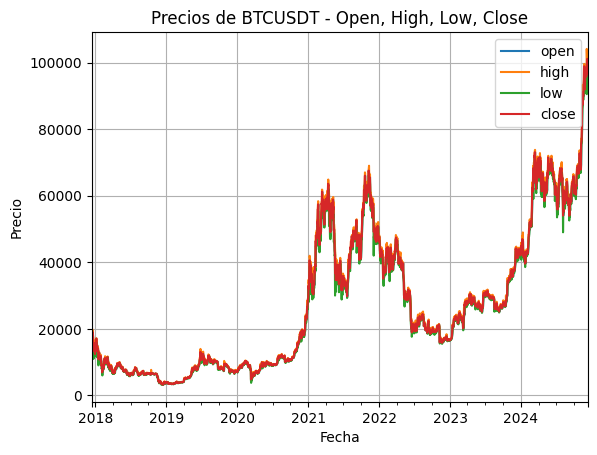


Visualizando datos de volumen...


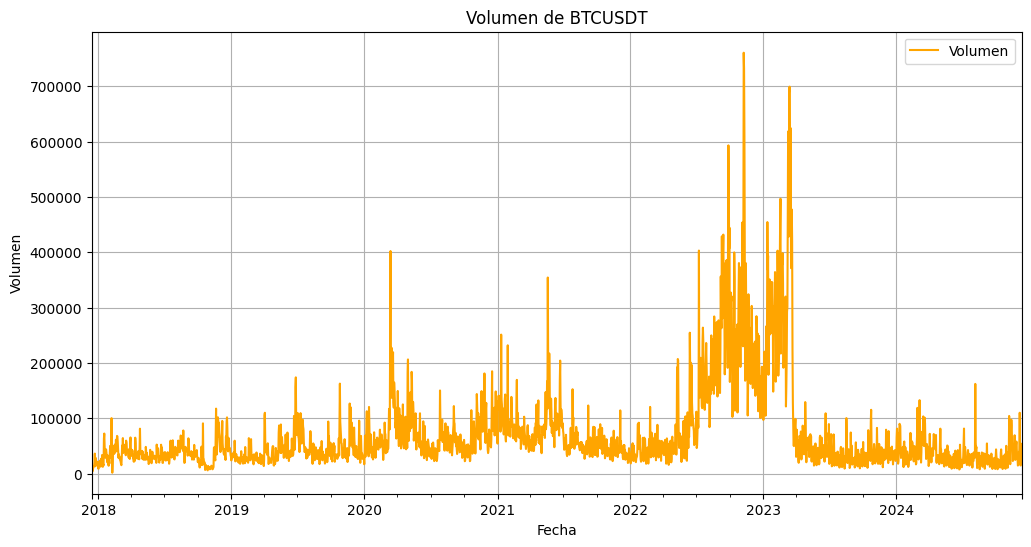


Visualizando datos de diferencias...


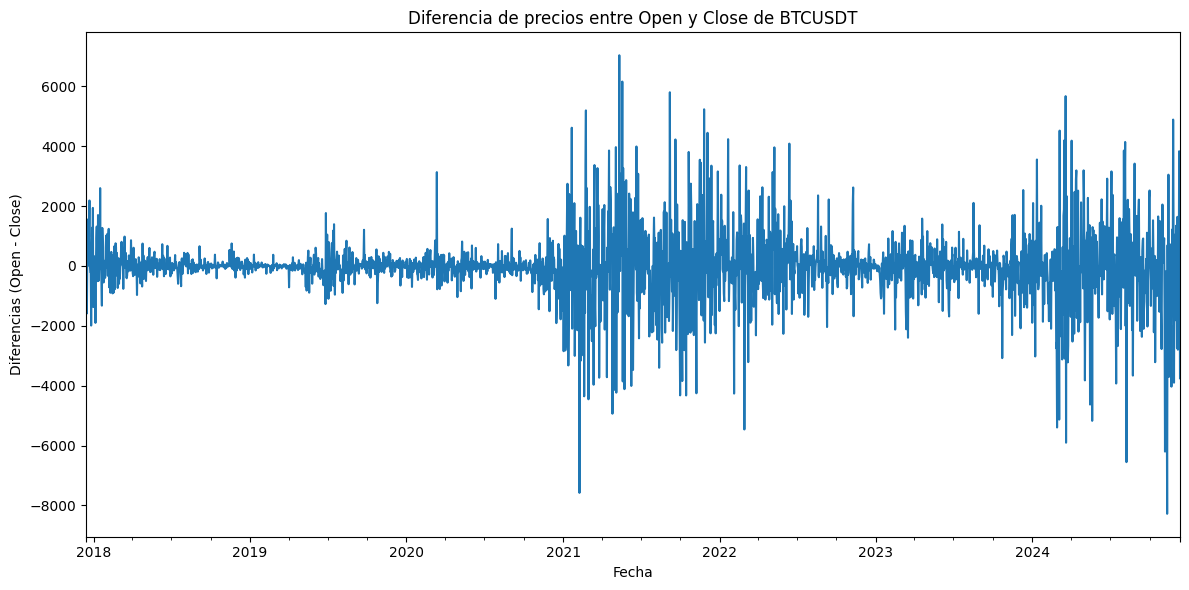


Visualizando datos de diferencias...


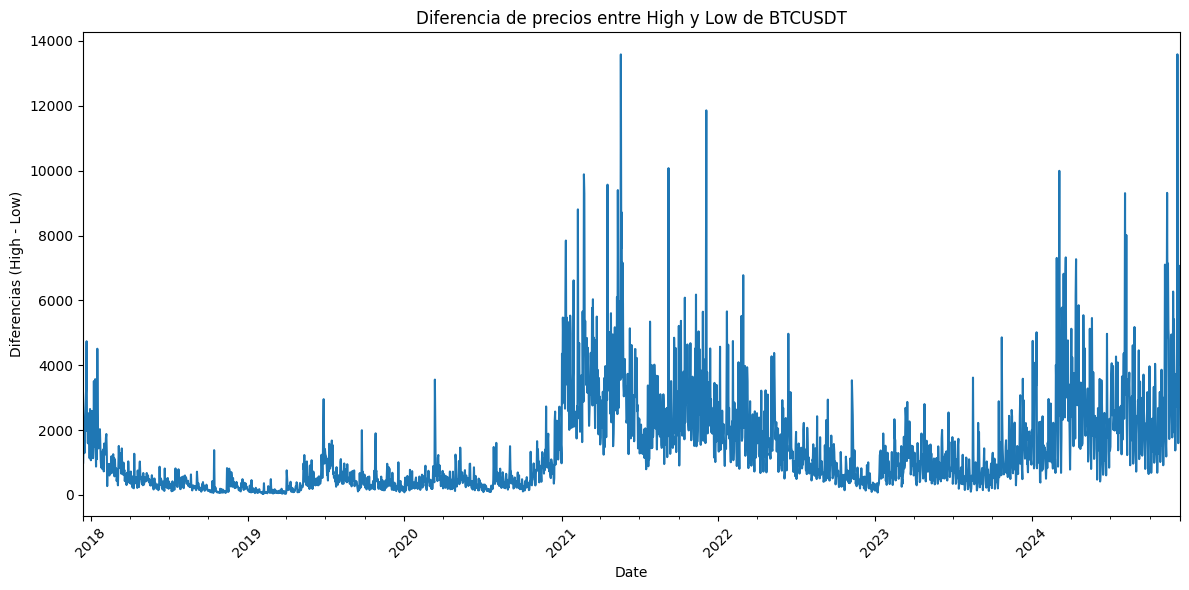

In [405]:
crypto.EDA()


Test de Dickey-Fuller en la serie original:

Test de Dickey-Fuller tras 1 diferenciación(es):

Análisis ACF y PACF en la serie estacionaria:
Interpretación de los patrones de ACF y PACF...
Gráfico ACF: mide la correlación entre una variable y sus valores rezagados.


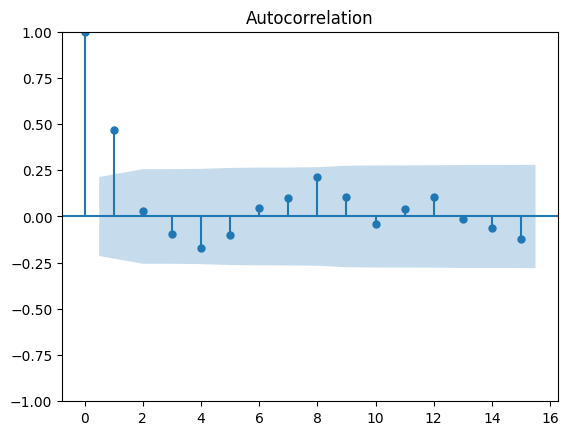

Gráfico PACF: mide la correlación entre una variable y sus valores rezagados después de eliminar el efecto de otros retardos.


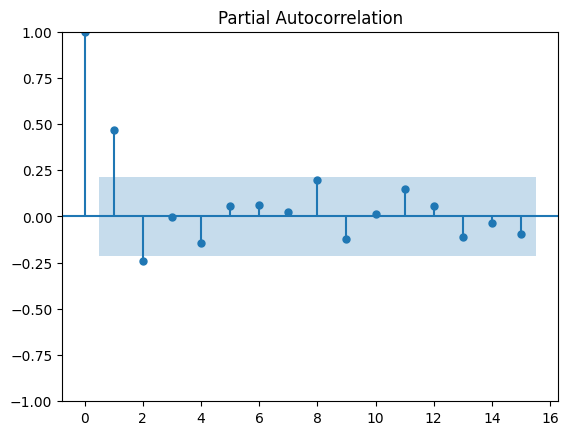

['Diferenciación 1: Estadístico ADF = -5.400125641365545, p-valor = 3.3851463443585554e-06',
 'La serie es estacionaria tras 1 diferenciación(es).',
 'Ambos ACF y PACF muestran un decaimiento gradual. Esto sugiere un modelo ARMA (o ARIMA si d > 0).',
 'Valores óptimos estimados: p=0, d=1, q=0']

In [406]:
crypto.TimeSeriesAnalysis('close')

Métricas para Baseline (mean):
mse: 477949107.2741
rmse: 21862.0472
mae: 18250.2386
mape: 137.4600
rmsle: 0.9451
smape: 70.8486


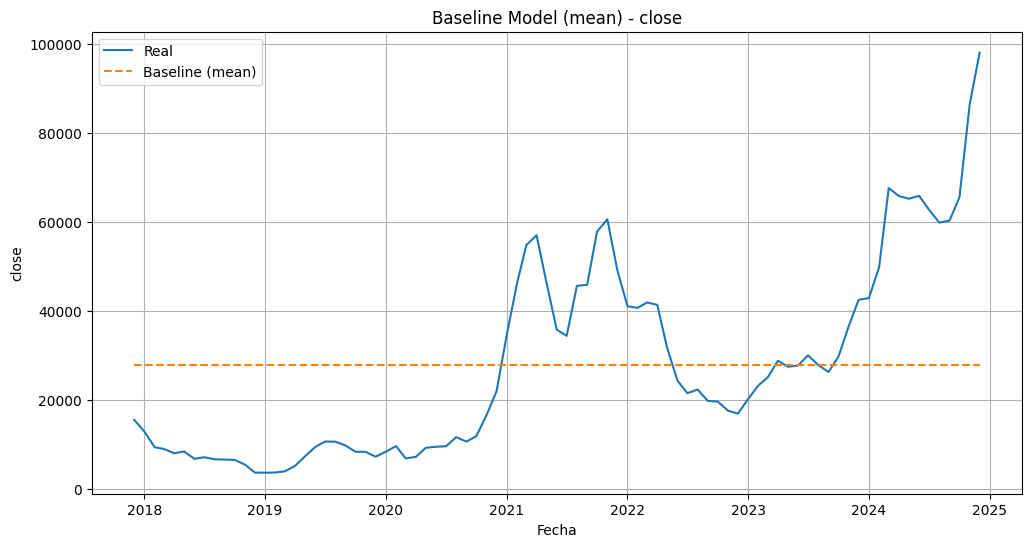

{'mse': 477949107.27413297,
 'rmse': 21862.04718854419,
 'mae': 18250.238579255012,
 'mape': 137.45995255435622,
 'rmsle': 0.9451233836643632,
 'smape': 70.84857358765613}

In [407]:
crypto.BaselineModel('close', method='mean')

Métricas para Baseline (previous):
mse: 31151180.3438
rmse: 5581.3242
mae: 3510.4571
mape: 13.5784
rmsle: 0.1804
smape: 13.4200


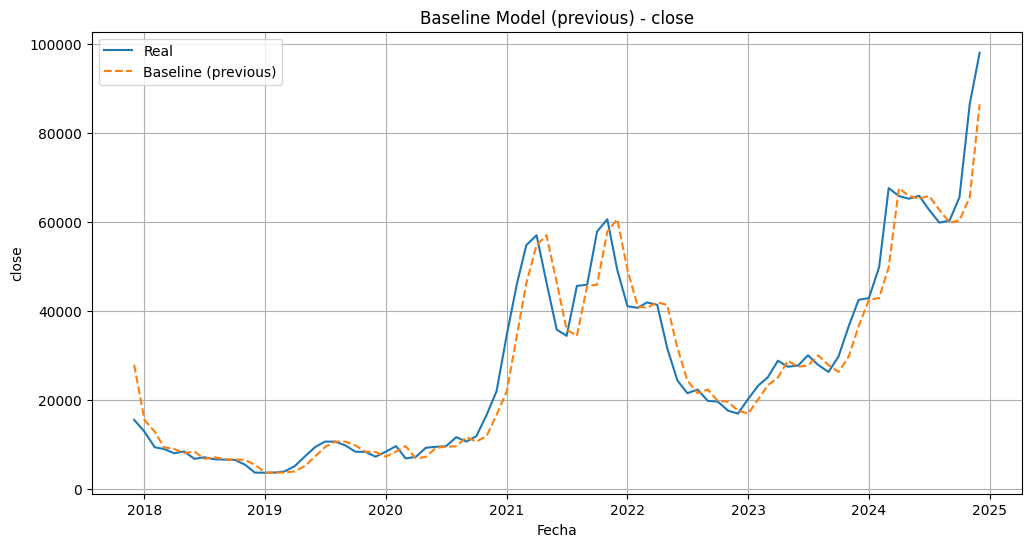

{'mse': 31151180.343804162,
 'rmse': 5581.324246431501,
 'mae': 3510.4570686873913,
 'mape': 13.578368672455031,
 'rmsle': 0.18039543242777878,
 'smape': 13.420047962401483}

In [408]:
crypto.BaselineModel('close', method='previous')


Probando modelo: ARIMA

Entrenando ARIMA(0, 1, 0) en la serie 'close' (Intento 1)...

⚠️ Advertencia: Las predicciones son constantes.
Ajustando automáticamente los parámetros con AutoARIMA... (Intento 1)
Probando combinaciones de parámetros...

Mejor modelo encontrado:
ARIMA(0, 1, 1) - AIC: 1664.3366556060237
Nuevos parámetros encontrados: p=0, d=1, q=1

Entrenando ARIMA(0, 1, 1) en la serie 'close' (Intento 2)...

⚠️ Advertencia: Las predicciones son constantes.
El modelo ARIMA falló con el error: Error al entrenar el modelo ARIMA: No se pudo encontrar un modelo adecuado después de varios intentos.

Probando modelo: SARIMA

Entrenando modelo SARIMA sin bono del Tesoro...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.16760D+00    |proj g|=  2.30717D-01

At iterate    5    f=  8.02622D+00    |proj g|=  1.49339D-02

At iterate   10    f=  8.

 This problem is unconstrained.


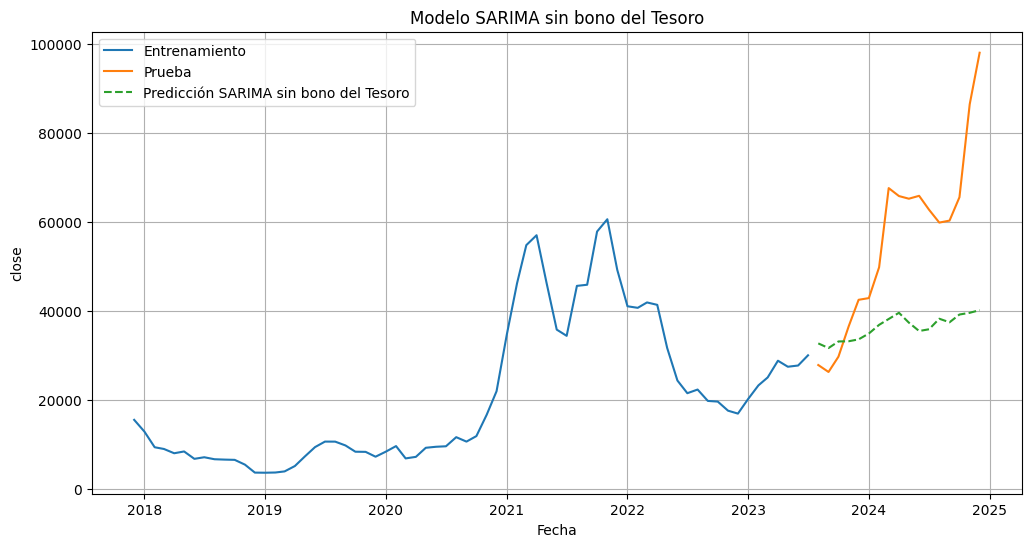

Métricas para SARIMA:
mse: 682821250.1324
rmse: 26130.8486
mae: 21378.5136
mape: 33.3262
rmsle: 0.4825
smape: 41.3047

Probando modelo: Holt-Winters

Entrenando modelo Holt-Winters...

Métricas del modelo Holt-Winters:
mse: 886722261.2440
rmse: 29777.8821
mae: 24288.2617
mape: 37.6321
rmsle: 0.5865
smape: 48.6768


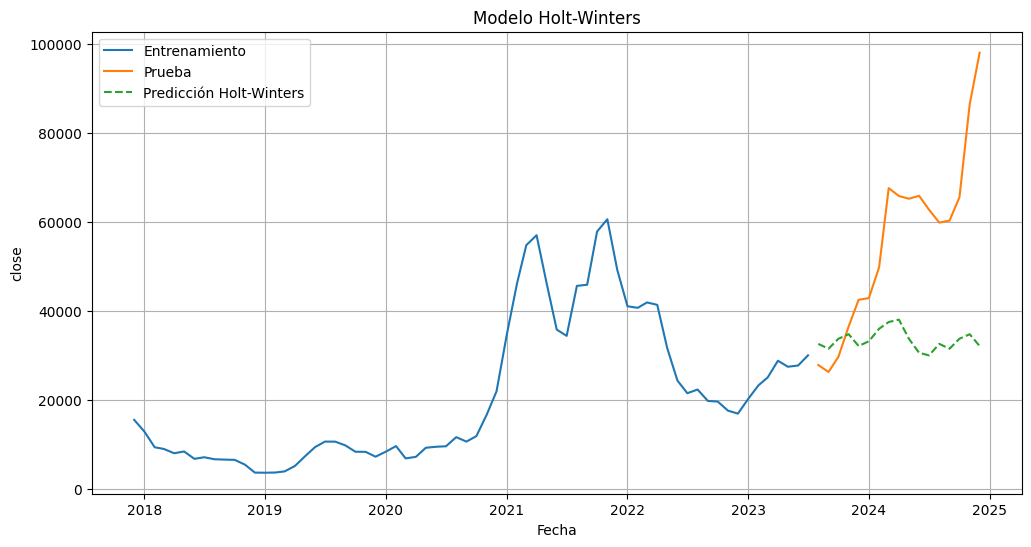

14:40:15 - cmdstanpy - INFO - Chain [1] start processing


Métricas para Holt-Winters:
mse: 886722261.2440
rmse: 29777.8821
mae: 24288.2617
mape: 37.6321
rmsle: 0.5865
smape: 48.6768

Probando modelo: Prophet

Entrenando modelo Prophet sin bono del Tesoro...


14:40:15 - cmdstanpy - INFO - Chain [1] done processing


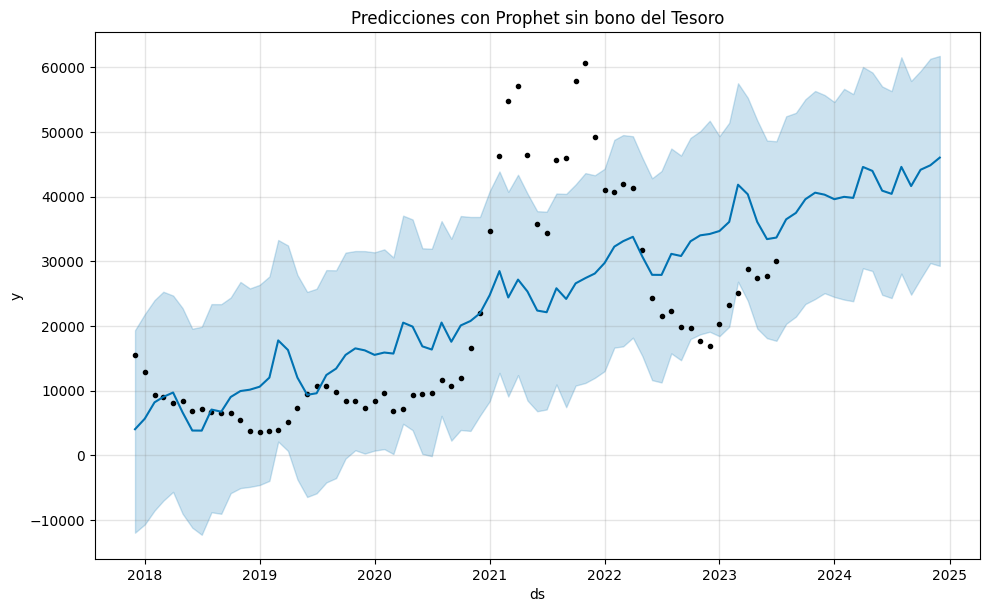

Métricas para Prophet:
mse: 513539577.6266
rmse: 22661.4116
mae: 18600.2899
mape: 30.6232
rmsle: 0.4019
smape: 35.0883

Probando modelo: OLS

Entrenando modelo OLS sin bono del Tesoro...
El modelo OLS falló con el error: name 'calculate_metrics' is not defined

Probando modelo: Exponential

Entrenando modelo de Predicción Exponencial...


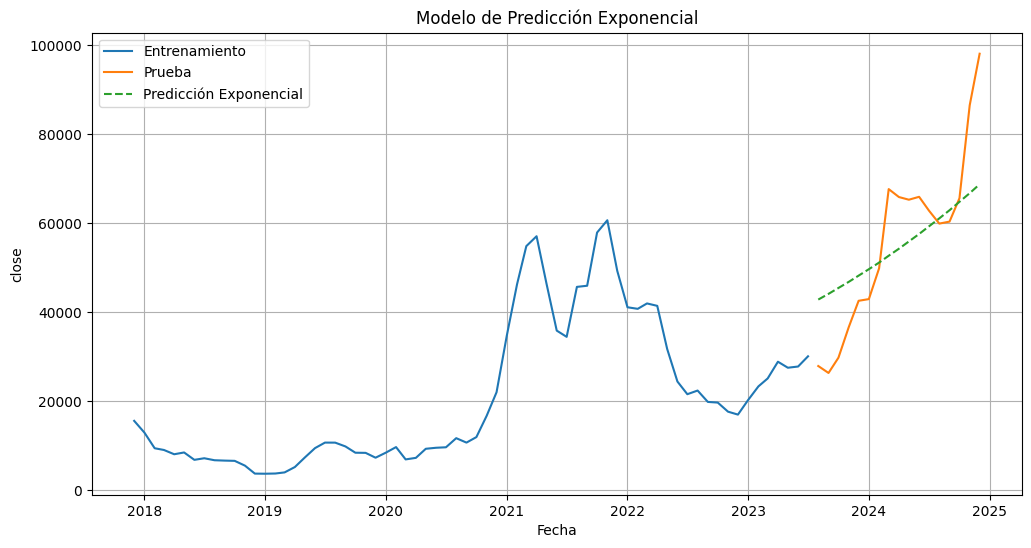

Métricas para Exponential:
mse: 162415144.1264
rmse: 12744.2200
mae: 10226.0421
mape: 21.5358
rmsle: 0.2510
smape: 19.7621

Probando modelo: LSTM
El modelo LSTM falló con el error: tuple index out of range

Mejor modelo encontrado: Exponential
Métricas del mejor modelo:
mse: 162415144.1264
rmse: 12744.2200
mae: 10226.0421
mape: 21.5358
rmsle: 0.2510
smape: 19.7621


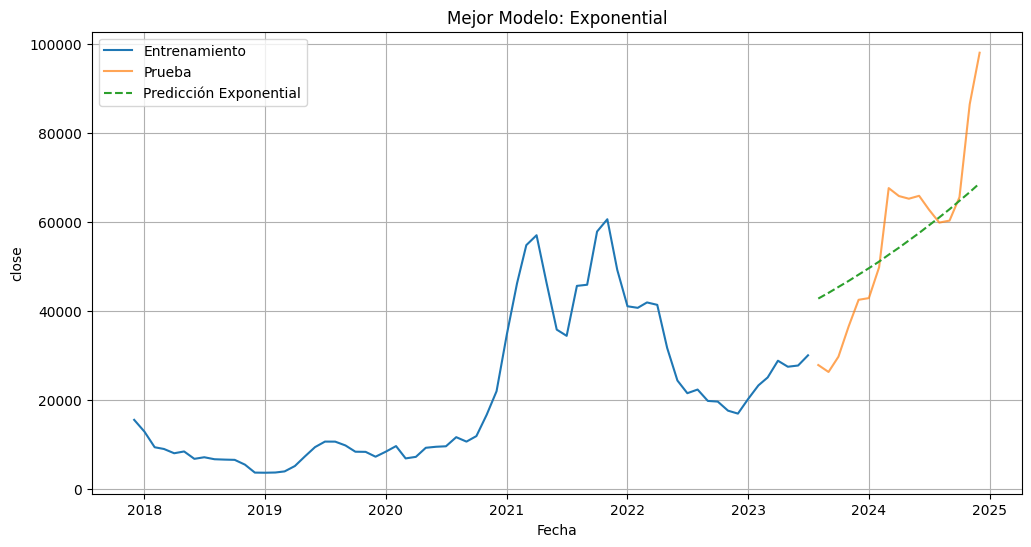


Mejor modelo seleccionado:
Nombre: Exponential
Métricas: {'mse': 162415144.1263727, 'rmse': 12744.220028168562, 'mae': 10226.04211933152, 'mape': 21.53580143786782, 'rmsle': 0.250987871906196, 'smape': 19.762141214042774}


In [409]:
# Ejecutar el pipeline
result = crypto.ModelPipeline('close')

# Mostrar resultados del mejor modelo
print("\nMejor modelo seleccionado:")
print(f"Nombre: {result['model_name']}")
print(f"Métricas: {result['metrics']}")

In [410]:
# Agregar datos del bono del Tesoro
crypto.add_treasury_data()

# Calcular correlación
correlation = crypto.calculate_correlation('close')
print(f"Correlación: {correlation:.4f}")


Descargando datos del bono del Tesoro de EE.UU. (^TNX)...


[*********************100%***********************]  1 of 1 completed


Datos del bono del Tesoro añadidos exitosamente.

Correlación entre close y el bono del Tesoro de EE.UU.: 0.3416
Correlación: 0.3416



Probando modelo: ARIMA

Entrenando ARIMA(0, 1, 1) en la serie 'close' (Intento 1)...

⚠️ Advertencia: Las predicciones son constantes.
Ajustando automáticamente los parámetros con AutoARIMA... (Intento 1)
Probando combinaciones de parámetros...

Mejor modelo encontrado:
ARIMA(0, 1, 1) - AIC: 1664.3366556060237
Nuevos parámetros encontrados: p=0, d=1, q=1

Entrenando ARIMA(0, 1, 1) en la serie 'close' (Intento 2)...

⚠️ Advertencia: Las predicciones son constantes.
El modelo ARIMA falló con el error: Error al entrenar el modelo ARIMA: No se pudo encontrar un modelo adecuado después de varios intentos.

Probando modelo: SARIMA

Entrenando modelo SARIMA con bono del Tesoro...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.13101D+00    |proj g|=  2.19739D-01

At iterate    5    f=  8.00675D+00    |proj g|=  1.65504D-02

At iterate   10    f=  8.

 This problem is unconstrained.



At iterate   45    f=  7.95851D+00    |proj g|=  5.92797D-04

At iterate   50    f=  7.95608D+00    |proj g|=  1.71593D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     55      1     0     0   1.716D-02   7.956D+00
  F =   7.9560843088596336     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


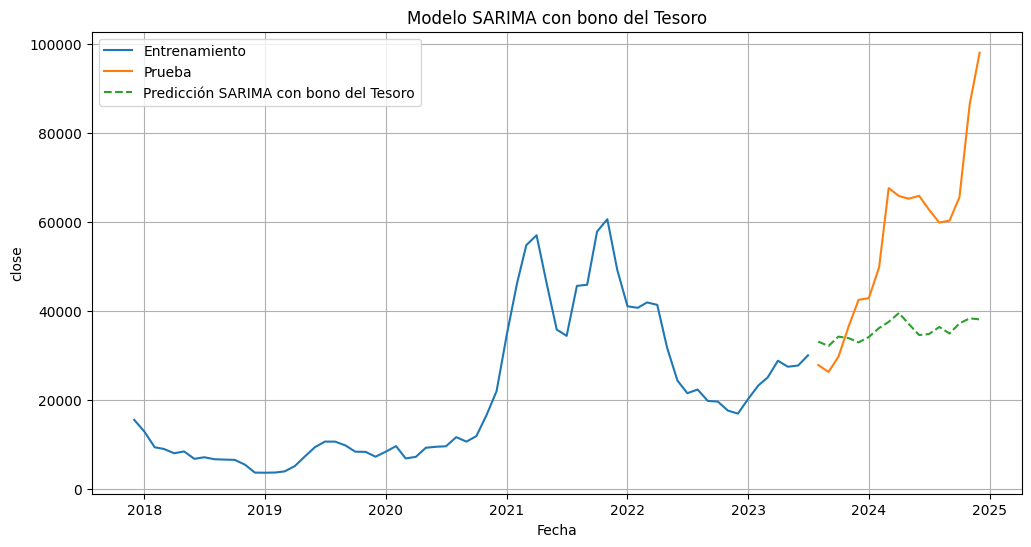

Métricas para SARIMA:
mse: 736307859.3770
rmse: 27134.9933
mae: 22326.0821
mape: 34.9887
rmsle: 0.5101
smape: 43.6976

Probando modelo: Holt-Winters

Entrenando modelo Holt-Winters...

Métricas del modelo Holt-Winters:
mse: 886722261.2440
rmse: 29777.8821
mae: 24288.2617
mape: 37.6321
rmsle: 0.5865
smape: 48.6768


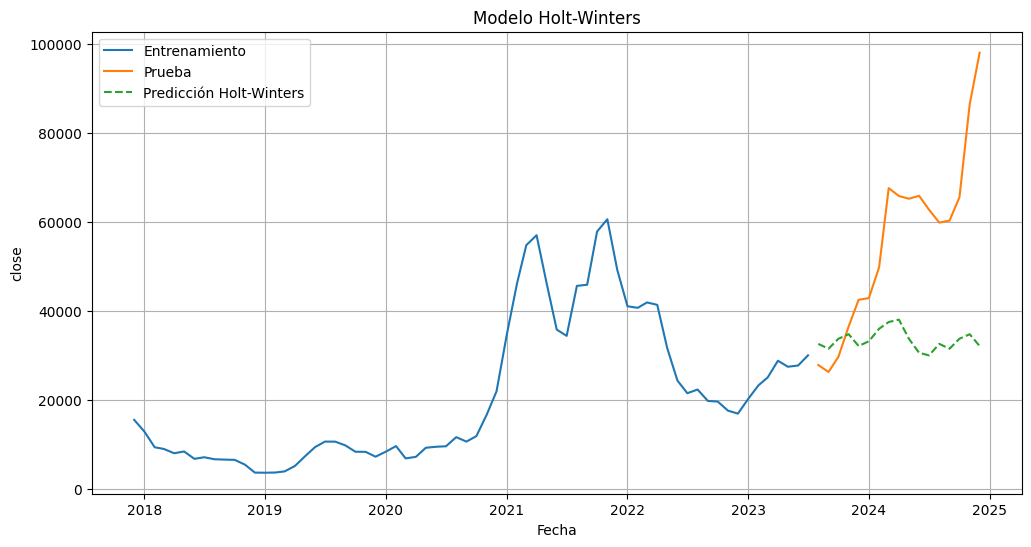

14:40:40 - cmdstanpy - INFO - Chain [1] start processing


Métricas para Holt-Winters:
mse: 886722261.2440
rmse: 29777.8821
mae: 24288.2617
mape: 37.6321
rmsle: 0.5865
smape: 48.6768

Probando modelo: Prophet

Entrenando modelo Prophet con bono del Tesoro...


14:40:40 - cmdstanpy - INFO - Chain [1] done processing


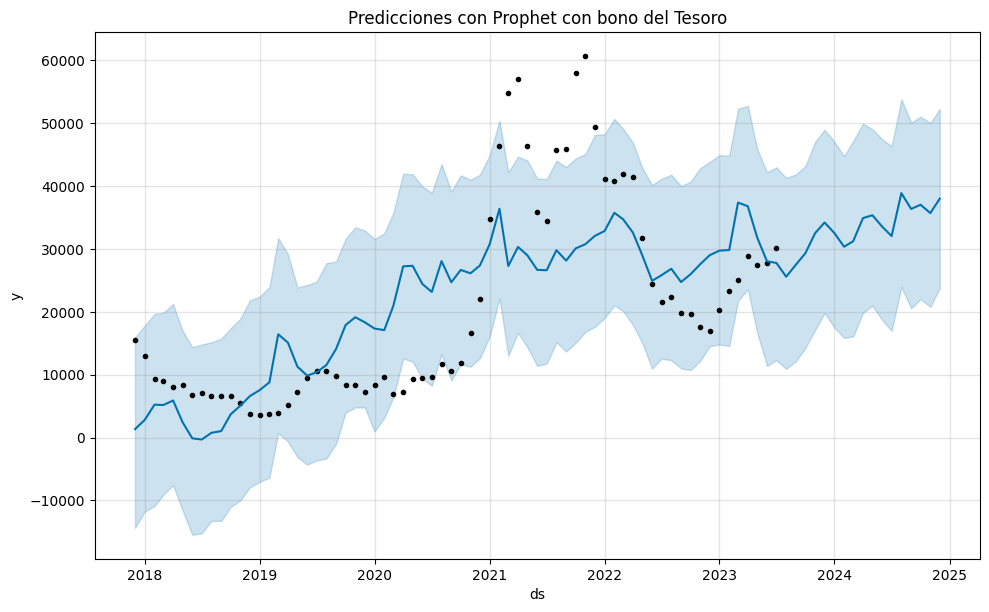

Métricas para Prophet:
mse: 812246150.0150
rmse: 28499.9325
mae: 23033.1705
mape: 34.8260
rmsle: 0.5501
smape: 45.2343

Probando modelo: OLS

Entrenando modelo OLS con bono del Tesoro...
El modelo OLS falló con el error: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

Probando modelo: Exponential

Entrenando modelo de Predicción Exponencial...


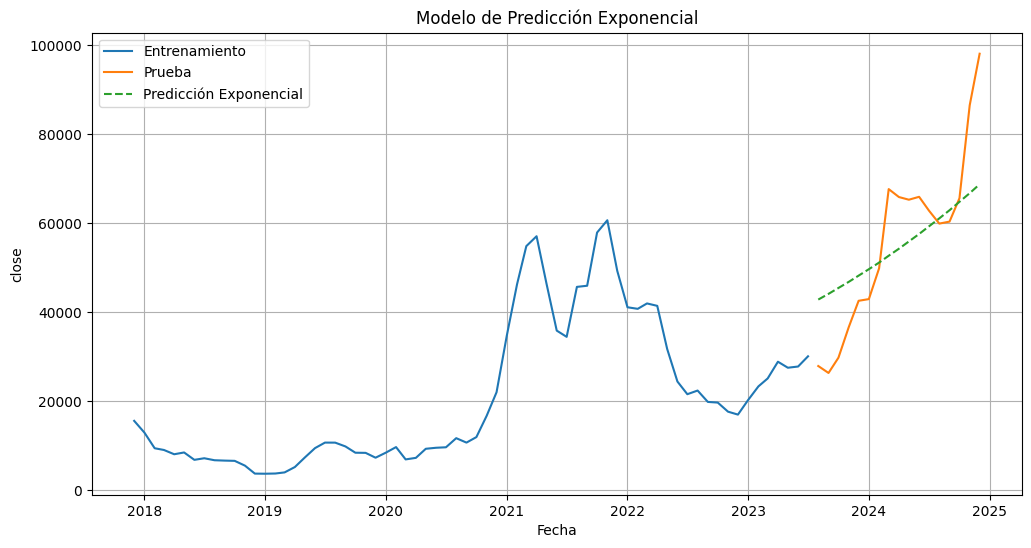

Métricas para Exponential:
mse: 162415144.1264
rmse: 12744.2200
mae: 10226.0421
mape: 21.5358
rmsle: 0.2510
smape: 19.7621

Probando modelo: LSTM
El modelo LSTM falló con el error: tuple index out of range

Mejor modelo encontrado: Exponential
Métricas del mejor modelo:
mse: 162415144.1264
rmse: 12744.2200
mae: 10226.0421
mape: 21.5358
rmsle: 0.2510
smape: 19.7621


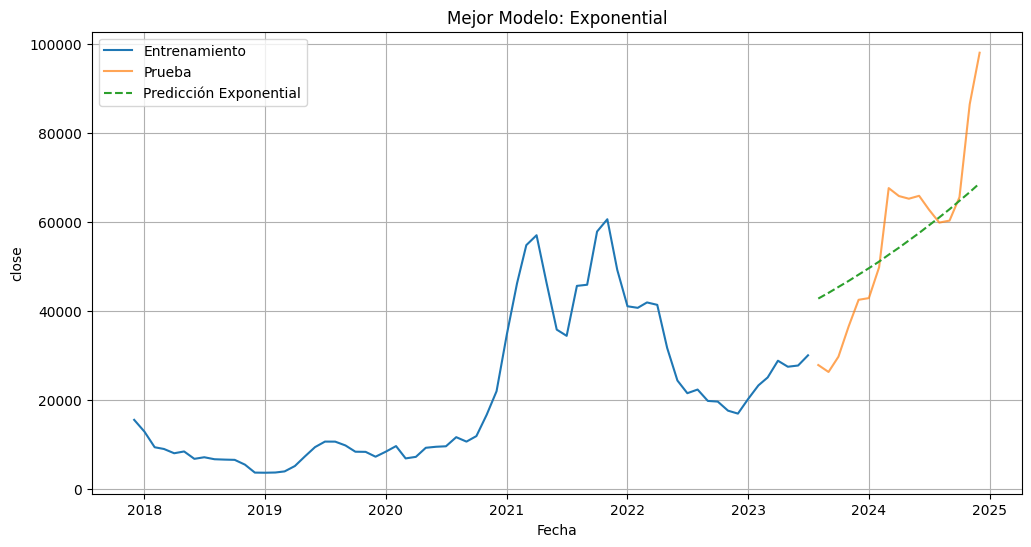

{'model_name': 'Exponential',
 'model': {'model_fit': LinearRegression(),
  'forecast': array([42818.33644567, 44104.79781562, 45429.90954761, 46794.83285063,
         48200.76382094, 49648.93449022, 51140.61390527, 52677.10924002,
         54259.76694106, 55889.97390753, 57569.15870648, 59298.79282474,
         61080.39195838, 62915.51734097, 64805.77711165, 66752.82772442,
         68758.37539965]),
  'metrics': {'mse': 162415144.1263727,
   'rmse': 12744.220028168562,
   'mae': 10226.04211933152,
   'mape': 21.53580143786782,
   'rmsle': 0.250987871906196,
   'smape': 19.762141214042774}},
 'metrics': {'mse': 162415144.1263727,
  'rmse': 12744.220028168562,
  'mae': 10226.04211933152,
  'mape': 21.53580143786782,
  'rmsle': 0.250987871906196,
  'smape': 19.762141214042774},
 'predictions': array([42818.33644567, 44104.79781562, 45429.90954761, 46794.83285063,
        48200.76382094, 49648.93449022, 51140.61390527, 52677.10924002,
        54259.76694106, 55889.97390753, 57569.1587064

In [412]:
crypto.ModelPipeline('close', include_treasury=True)